<a href="https://colab.research.google.com/github/Amal1703/demo/blob/main/Covid_19_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This lab is dedicated to application of an advanced analysis of Big Data to the spread of COVID-19 in the world. We will study how to make image recognition of a chest X-ray to provide a diagnosis forecast.

In [ ]:
!pip install mahotas
pip install tensorflow

In [ ]:
import numpy as np
import mahotas as mh
import kagglehub
import shutil
import os
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

**download data**

In [ ]:
# 1. Download to KaggleHub default cache
src_path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

# 2. Choose your target directory
dst_path = "/content/"

# 3. Copy all files from cache to your directory
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print("Dataset available at:", dst_path)

100%|██████████| 158M/158M [00:02<00:00, 78.0MB/s]

Extracting files...


Dataset available at: /content/


Images have to be of the same size (height and width) for classification => transformation

Data visualisation

Shape: (1582, 1333, 3)


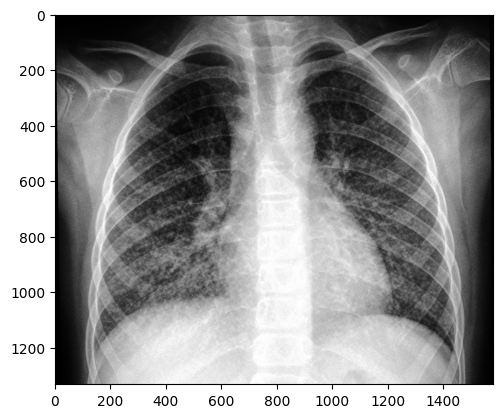

In [ ]:
# Ouvrir l'image
img = Image.open("/content/Covid19-dataset/train/Viral Pneumonia/01.jpeg")
width, height= img.size # width, heigh
mode = img.mode
channels = 1 if mode == "L" else 3  # "L" = grayscale, "RGB" = 3 canaux
#color img = 3, gray img = 1
print("Shape:", (width, height, channels))
plt.imshow(img)

Shape: (1944, 1708, 3)


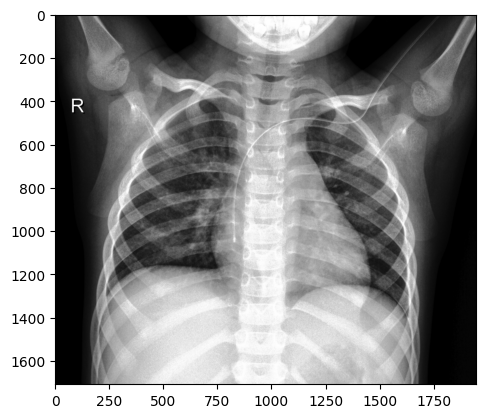

In [ ]:
# Ouvrir l'image
img = Image.open("/content/Covid19-dataset/train/Normal/01.jpeg")
width, height= img.size # width, heigh
mode = img.mode
channels = 1 if mode == "L" else 3  # "L" = grayscale, "RGB" = 3 canaux
#color img = 3, gray img = 1
print("Shape:", (width, height, channels))
plt.imshow(img)

Shape: (4248, 3480, 3)


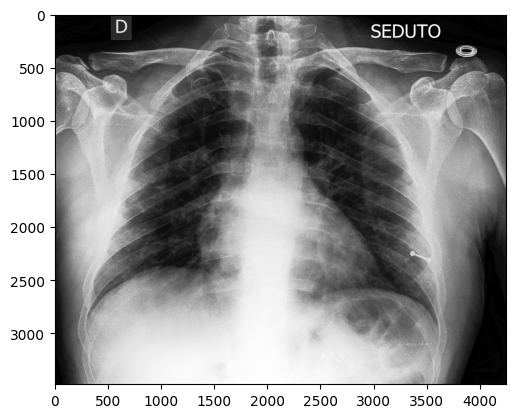

In [ ]:
# Ouvrir l'image
img = Image.open("/content/Covid19-dataset/train/Covid/01.jpeg")
width, height= img.size # width, heigh
mode = img.mode
channels = 1 if mode == "L" else 3  # "L" = grayscale, "RGB" = 3 canaux
#color img = 3, gray img = 1
print("Shape:", (width, height, channels))
plt.imshow(img)

Transformation (to gray image , a tester for color img = 3)

In [ ]:
# Redimensionner data

def get_data(output_folder,target_size):
 k=[]
 for folder in os.listdir(output_folder):
  for i in range(len(os.listdir(output_folder))):
    path=os.path.join(output_folder, os.listdir(output_folder)[i]) #ouvrir dossier Normal ou Covid ou Viral Pneumonia
    for filename in os.listdir(path):
       if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        # Chemin de l'image
        img_path = os.path.join(path, filename)

        # Ouvrir l'image
        img = mh.imread(img_path)

        # Redimensionner à target_size
        if img.ndim == 3: #pour une image couleur
            img_resized = mh.resize_to(img, [target_size, target_size, img.shape[2]]) # resize of RGB and png images
        else: # img.ndim=2, pour une image gray
            img_resized = mh.resize_to(img, [target_size, target_size]) # resize of grey images

        # Convertir en niveaux de gris
        if img.ndim == 3:
             img_resized = mh.colors.rgb2grey(img_resized[:,:,:3], dtype = np.uint8)

        data=[]
        data.append(img_resized)
        data.append(os.listdir(output_folder)[i])#concate matrix of image et classe (Normal ou Covid ou Viral Pneumonia)

        k.append(data) #concate all data

 return k


In [ ]:
target_size = 224
train_data=get_data("/content/Covid19-dataset/train",target_size)
test_data=get_data("/content/Covid19-dataset/test",target_size)

In [ ]:
data_concate=train_data+test_data #concate

split data

In [ ]:
labels = [label for _, label in data_concate]
num_classes = len(set(labels))
list(set(labels))[0] # 3 classes name : Covid, Viral Pneumonia, Normal

X_train=[]
y_train=[]

X_test=[]
y_test=[]

X_val=[]
y_val=[]

for i in range (num_classes):

 matrices = [m for m, l in data_concate if l == list(set(labels))[i]]
 y_encoded=[list(set(labels))[i]] * len(matrices)

# 70% train , 30% temp pour chaque classe
 X_train_1, X_temp, y_train_1, y_temp = train_test_split(
    matrices, y_encoded, test_size=0.3, random_state=50, stratify=y_encoded)

# from temp: 10% val , 20% test
 X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(
    X_temp, y_temp, test_size=0.66, random_state=50, stratify=y_temp)

# concatiner tous les donnes des 3 classes
 X_train.extend(X_train_1)
 y_train.extend(y_train_1)

 X_test.extend(X_test_1)
 y_test.extend(y_test_1)

 X_val.extend(X_val_1)
 y_val.extend(y_val_1)


Normlize data

In [ ]:
# Normalize the data
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

Encoder output (donner apprentissage il faut que normal =0 ... (apprentisagge aprend 0, 1... et non pas les noms comme normal ou covid))

In [ ]:
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded   = encoder.transform(y_val)
y_test_encoded  = encoder.transform(y_test)

print(encoder.classes_)

['Covid' 'Normal' 'Viral Pneumonia']


CNN

In [ ]:
def build_cnn(input_shape, num_classes):

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Flatten(),

        layers.Dense(128, activation='relu'),
       # layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
input_shape = (target_size, target_size, 1)   # example: (224, 224, 1)
num_classes = len(encoder.classes_)

model = build_cnn(input_shape, num_classes)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,566,371 (21.23 MB)

 Trainable params: 5,566,371 (21.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.000001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Stop training if validation loss does not improve for 15 epochs
early_stop = EarlyStopping(
    monitor='val_loss',    # monitor validation loss
    patience=15,            # wait for 3 epochs
    restore_best_weights=True  # restore model weights from best epoch
)

checkpoint = ModelCheckpoint(
    'best_model.h5',  # nom fichier model
    monitor='val_loss',  # métrique à surveiller
    save_best_only=True # ne sauvegarde que le meilleur modèle
)

In [ ]:
history = model.fit(
    X_train.reshape(-1, target_size, target_size, 1), # e.g. (nb total donner, target_size, target_size, 1)
    y_train_encoded, # e.g. (nb total donner)
    epochs=100,
    batch_size=15,
    validation_data=(X_val.reshape(-1, target_size, target_size, 1), y_val_encoded),
    callbacks=[checkpoint, early_stop]  # add EarlyStopping
)

Epoch 1/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.4188 - loss: 1.0985

45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 969ms/step - accuracy: 0.4190 - loss: 1.0985 - val_accuracy: 0.4375 - val_loss: 1.0984
Epoch 2/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.4266 - loss: 1.0984

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 931ms/step - accuracy: 0.4267 - loss: 1.0984 - val_accuracy: 0.4375 - val_loss: 1.0983
Epoch 3/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.4355 - loss: 1.0983

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 927ms/step - accuracy: 0.4354 - loss: 1.0983 - val_accuracy: 0.4375 - val_loss: 1.0981
Epoch 4/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.4321 - loss: 1.0981

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 918ms/step - accuracy: 0.4321 - loss: 1.0981 - val_accuracy: 0.4375 - val_loss: 1.0978
Epoch 5/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.4228 - loss: 1.0978

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 961ms/step - accuracy: 0.4230 - loss: 1.0978 - val_accuracy: 0.4375 - val_loss: 1.0975
Epoch 6/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.4200 - loss: 1.0975

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 941ms/step - accuracy: 0.4203 - loss: 1.0975 - val_accuracy: 0.4375 - val_loss: 1.0970
Epoch 7/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.4429 - loss: 1.0968

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 931ms/step - accuracy: 0.4426 - loss: 1.0968 - val_accuracy: 0.4375 - val_loss: 1.0963
Epoch 8/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.4235 - loss: 1.0965

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 920ms/step - accuracy: 0.4237 - loss: 1.0965 - val_accuracy: 0.4375 - val_loss: 1.0956
Epoch 9/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.4330 - loss: 1.0956

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 932ms/step - accuracy: 0.4329 - loss: 1.0956 - val_accuracy: 0.4375 - val_loss: 1.0947
Epoch 10/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.4422 - loss: 1.0943

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 933ms/step - accuracy: 0.4419 - loss: 1.0943 - val_accuracy: 0.4375 - val_loss: 1.0936
Epoch 11/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.4300 - loss: 1.0937

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 950ms/step - accuracy: 0.4301 - loss: 1.0937 - val_accuracy: 0.4375 - val_loss: 1.0925
Epoch 12/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.4506 - loss: 1.0919

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 928ms/step - accuracy: 0.4502 - loss: 1.0919 - val_accuracy: 0.4375 - val_loss: 1.0912
Epoch 13/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.4574 - loss: 1.0902

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 922ms/step - accuracy: 0.4568 - loss: 1.0902 - val_accuracy: 0.4375 - val_loss: 1.0899
Epoch 14/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.4454 - loss: 1.0892

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 921ms/step - accuracy: 0.4451 - loss: 1.0892 - val_accuracy: 0.4375 - val_loss: 1.0885
Epoch 15/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.4372 - loss: 1.0882

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 952ms/step - accuracy: 0.4370 - loss: 1.0882 - val_accuracy: 0.4375 - val_loss: 1.0871
Epoch 16/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.4006 - loss: 1.0910

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 925ms/step - accuracy: 0.4013 - loss: 1.0910 - val_accuracy: 0.4375 - val_loss: 1.0857
Epoch 17/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.4358 - loss: 1.0863

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 924ms/step - accuracy: 0.4357 - loss: 1.0863 - val_accuracy: 0.4375 - val_loss: 1.0842
Epoch 18/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.3893 - loss: 1.0904

45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 924ms/step - accuracy: 0.3902 - loss: 1.0903 - val_accuracy: 0.4375 - val_loss: 1.0830
Epoch 19/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.4652 - loss: 1.0794

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 958ms/step - accuracy: 0.4645 - loss: 1.0795 - val_accuracy: 0.4375 - val_loss: 1.0814
Epoch 20/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.4325 - loss: 1.0819

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 979ms/step - accuracy: 0.4325 - loss: 1.0819 - val_accuracy: 0.4375 - val_loss: 1.0802
Epoch 21/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.4266 - loss: 1.0825

45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 933ms/step - accuracy: 0.4267 - loss: 1.0825 - val_accuracy: 0.4375 - val_loss: 1.0789
Epoch 22/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.3989 - loss: 1.0861

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 961ms/step - accuracy: 0.3996 - loss: 1.0859 - val_accuracy: 0.4375 - val_loss: 1.0779
Epoch 23/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.4875 - loss: 1.0687

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 960ms/step - accuracy: 0.4863 - loss: 1.0690 - val_accuracy: 0.4375 - val_loss: 1.0767
Epoch 24/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.4469 - loss: 1.0748

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 957ms/step - accuracy: 0.4466 - loss: 1.0749 - val_accuracy: 0.4375 - val_loss: 1.0758
Epoch 25/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.4428 - loss: 1.0749

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 955ms/step - accuracy: 0.4425 - loss: 1.0749 - val_accuracy: 0.4375 - val_loss: 1.0749
Epoch 26/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.4496 - loss: 1.0723

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 930ms/step - accuracy: 0.4492 - loss: 1.0724 - val_accuracy: 0.4375 - val_loss: 1.0740
Epoch 27/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.4224 - loss: 1.0776

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 949ms/step - accuracy: 0.4226 - loss: 1.0776 - val_accuracy: 0.4375 - val_loss: 1.0734
Epoch 28/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.4321 - loss: 1.0746

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 928ms/step - accuracy: 0.4321 - loss: 1.0746 - val_accuracy: 0.4375 - val_loss: 1.0724
Epoch 29/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.4233 - loss: 1.0772

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 959ms/step - accuracy: 0.4235 - loss: 1.0771 - val_accuracy: 0.4375 - val_loss: 1.0716
Epoch 30/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.4173 - loss: 1.0777

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 944ms/step - accuracy: 0.4176 - loss: 1.0776 - val_accuracy: 0.4375 - val_loss: 1.0710
Epoch 31/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.4305 - loss: 1.0738

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 965ms/step - accuracy: 0.4306 - loss: 1.0738 - val_accuracy: 0.4375 - val_loss: 1.0703
Epoch 32/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.4409 - loss: 1.0699

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 935ms/step - accuracy: 0.4407 - loss: 1.0699 - val_accuracy: 0.4375 - val_loss: 1.0695
Epoch 33/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.4134 - loss: 1.0765

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 933ms/step - accuracy: 0.4138 - loss: 1.0764 - val_accuracy: 0.4375 - val_loss: 1.0689
Epoch 34/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.4656 - loss: 1.0605

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 961ms/step - accuracy: 0.4649 - loss: 1.0608 - val_accuracy: 0.4375 - val_loss: 1.0682
Epoch 35/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.4153 - loss: 1.0754

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 966ms/step - accuracy: 0.4157 - loss: 1.0753 - val_accuracy: 0.4375 - val_loss: 1.0677
Epoch 36/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.4057 - loss: 1.0786

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 969ms/step - accuracy: 0.4063 - loss: 1.0784 - val_accuracy: 0.4375 - val_loss: 1.0672
Epoch 37/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.4201 - loss: 1.0737

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 944ms/step - accuracy: 0.4203 - loss: 1.0737 - val_accuracy: 0.4375 - val_loss: 1.0666
Epoch 38/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.4120 - loss: 1.0757

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 954ms/step - accuracy: 0.4124 - loss: 1.0756 - val_accuracy: 0.4375 - val_loss: 1.0660
Epoch 39/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.4512 - loss: 1.0619

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 947ms/step - accuracy: 0.4508 - loss: 1.0620 - val_accuracy: 0.4375 - val_loss: 1.0653
Epoch 40/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.4564 - loss: 1.0593

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 946ms/step - accuracy: 0.4559 - loss: 1.0595 - val_accuracy: 0.4375 - val_loss: 1.0648
Epoch 41/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.4346 - loss: 1.0671

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 946ms/step - accuracy: 0.4345 - loss: 1.0671 - val_accuracy: 0.4375 - val_loss: 1.0643
Epoch 42/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.4084 - loss: 1.0753

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 978ms/step - accuracy: 0.4089 - loss: 1.0751 - val_accuracy: 0.4375 - val_loss: 1.0638
Epoch 43/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.4362 - loss: 1.0651

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 951ms/step - accuracy: 0.4361 - loss: 1.0651 - val_accuracy: 0.4375 - val_loss: 1.0631
Epoch 44/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.4257 - loss: 1.0679

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 983ms/step - accuracy: 0.4259 - loss: 1.0678 - val_accuracy: 0.4375 - val_loss: 1.0626
Epoch 45/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.4285 - loss: 1.0655

45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 939ms/step - accuracy: 0.4286 - loss: 1.0655 - val_accuracy: 0.4375 - val_loss: 1.0620
Epoch 46/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.4614 - loss: 1.0536

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 988ms/step - accuracy: 0.4608 - loss: 1.0538 - val_accuracy: 0.4375 - val_loss: 1.0613
Epoch 47/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.4407 - loss: 1.0615

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 950ms/step - accuracy: 0.4405 - loss: 1.0616 - val_accuracy: 0.4375 - val_loss: 1.0607
Epoch 48/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.4345 - loss: 1.0629

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 974ms/step - accuracy: 0.4344 - loss: 1.0629 - val_accuracy: 0.4375 - val_loss: 1.0601
Epoch 49/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.4114 - loss: 1.0709

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 950ms/step - accuracy: 0.4118 - loss: 1.0707 - val_accuracy: 0.4375 - val_loss: 1.0595
Epoch 50/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.4361 - loss: 1.0602

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 984ms/step - accuracy: 0.4360 - loss: 1.0602 - val_accuracy: 0.4375 - val_loss: 1.0590
Epoch 51/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.4480 - loss: 1.0556

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 969ms/step - accuracy: 0.4476 - loss: 1.0557 - val_accuracy: 0.4375 - val_loss: 1.0583
Epoch 52/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.4291 - loss: 1.0623

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 955ms/step - accuracy: 0.4292 - loss: 1.0623 - val_accuracy: 0.4375 - val_loss: 1.0576
Epoch 53/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.4042 - loss: 1.0717

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 939ms/step - accuracy: 0.4048 - loss: 1.0715 - val_accuracy: 0.4375 - val_loss: 1.0570
Epoch 54/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.4630 - loss: 1.0486

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 967ms/step - accuracy: 0.4624 - loss: 1.0489 - val_accuracy: 0.4375 - val_loss: 1.0563
Epoch 55/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.4235 - loss: 1.0620

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 939ms/step - accuracy: 0.4237 - loss: 1.0620 - val_accuracy: 0.4375 - val_loss: 1.0556
Epoch 56/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.4088 - loss: 1.0671

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 950ms/step - accuracy: 0.4093 - loss: 1.0669 - val_accuracy: 0.4375 - val_loss: 1.0550
Epoch 57/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.4106 - loss: 1.0669

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 950ms/step - accuracy: 0.4111 - loss: 1.0667 - val_accuracy: 0.4375 - val_loss: 1.0543
Epoch 58/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.4484 - loss: 1.0510

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 974ms/step - accuracy: 0.4481 - loss: 1.0511 - val_accuracy: 0.4375 - val_loss: 1.0536
Epoch 59/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.4107 - loss: 1.0646

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 956ms/step - accuracy: 0.4112 - loss: 1.0644 - val_accuracy: 0.4375 - val_loss: 1.0529
Epoch 60/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.4675 - loss: 1.0414

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4667 - loss: 1.0417 - val_accuracy: 0.4375 - val_loss: 1.0522
Epoch 61/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.4358 - loss: 1.0546

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 964ms/step - accuracy: 0.4357 - loss: 1.0546 - val_accuracy: 0.4375 - val_loss: 1.0515
Epoch 62/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.4316 - loss: 1.0539

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 933ms/step - accuracy: 0.4316 - loss: 1.0539 - val_accuracy: 0.4375 - val_loss: 1.0508
Epoch 63/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.4139 - loss: 1.0608

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 960ms/step - accuracy: 0.4142 - loss: 1.0607 - val_accuracy: 0.4375 - val_loss: 1.0500
Epoch 64/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.4616 - loss: 1.0418

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 932ms/step - accuracy: 0.4610 - loss: 1.0420 - val_accuracy: 0.4375 - val_loss: 1.0491
Epoch 65/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.4212 - loss: 1.0568

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 966ms/step - accuracy: 0.4214 - loss: 1.0568 - val_accuracy: 0.4375 - val_loss: 1.0483
Epoch 66/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.4308 - loss: 1.0518

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 946ms/step - accuracy: 0.4308 - loss: 1.0518 - val_accuracy: 0.4375 - val_loss: 1.0474
Epoch 67/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.4176 - loss: 1.0559

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 980ms/step - accuracy: 0.4179 - loss: 1.0558 - val_accuracy: 0.4375 - val_loss: 1.0463
Epoch 68/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.4214 - loss: 1.0537

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 968ms/step - accuracy: 0.4216 - loss: 1.0536 - val_accuracy: 0.4375 - val_loss: 1.0451
Epoch 69/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.4213 - loss: 1.0530

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 981ms/step - accuracy: 0.4215 - loss: 1.0529 - val_accuracy: 0.4375 - val_loss: 1.0440
Epoch 70/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.4299 - loss: 1.0490

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 975ms/step - accuracy: 0.4299 - loss: 1.0489 - val_accuracy: 0.4375 - val_loss: 1.0429
Epoch 71/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.4187 - loss: 1.0530

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 954ms/step - accuracy: 0.4190 - loss: 1.0528 - val_accuracy: 0.4375 - val_loss: 1.0418
Epoch 72/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.4020 - loss: 1.0574

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 977ms/step - accuracy: 0.4027 - loss: 1.0572 - val_accuracy: 0.4375 - val_loss: 1.0407
Epoch 73/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.4318 - loss: 1.0438

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 960ms/step - accuracy: 0.4318 - loss: 1.0438 - val_accuracy: 0.4375 - val_loss: 1.0396
Epoch 74/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.4356 - loss: 1.0421

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 971ms/step - accuracy: 0.4355 - loss: 1.0421 - val_accuracy: 0.4375 - val_loss: 1.0385
Epoch 75/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.4325 - loss: 1.0425

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 956ms/step - accuracy: 0.4325 - loss: 1.0425 - val_accuracy: 0.4375 - val_loss: 1.0374
Epoch 76/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.4343 - loss: 1.0404

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 989ms/step - accuracy: 0.4343 - loss: 1.0404 - val_accuracy: 0.4375 - val_loss: 1.0363
Epoch 77/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.4490 - loss: 1.0343

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 971ms/step - accuracy: 0.4486 - loss: 1.0345 - val_accuracy: 0.4375 - val_loss: 1.0351
Epoch 78/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.4090 - loss: 1.0481

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 997ms/step - accuracy: 0.4095 - loss: 1.0479 - val_accuracy: 0.4375 - val_loss: 1.0339
Epoch 79/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.4210 - loss: 1.0419

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 987ms/step - accuracy: 0.4212 - loss: 1.0419 - val_accuracy: 0.4375 - val_loss: 1.0327
Epoch 80/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.4291 - loss: 1.0386

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 990ms/step - accuracy: 0.4292 - loss: 1.0385 - val_accuracy: 0.4375 - val_loss: 1.0315
Epoch 81/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.4312 - loss: 1.0347

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 994ms/step - accuracy: 0.4312 - loss: 1.0347 - val_accuracy: 0.4375 - val_loss: 1.0302
Epoch 82/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.4200 - loss: 1.0383

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 996ms/step - accuracy: 0.4203 - loss: 1.0382 - val_accuracy: 0.4375 - val_loss: 1.0289
Epoch 83/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.4221 - loss: 1.0368

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 976ms/step - accuracy: 0.4223 - loss: 1.0367 - val_accuracy: 0.4375 - val_loss: 1.0274
Epoch 84/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.4270 - loss: 1.0347

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 959ms/step - accuracy: 0.4271 - loss: 1.0346 - val_accuracy: 0.4375 - val_loss: 1.0259
Epoch 85/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.4397 - loss: 1.0274

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 989ms/step - accuracy: 0.4395 - loss: 1.0274 - val_accuracy: 0.4375 - val_loss: 1.0242
Epoch 86/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.4597 - loss: 1.0180

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 967ms/step - accuracy: 0.4591 - loss: 1.0182 - val_accuracy: 0.4375 - val_loss: 1.0226
Epoch 87/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.4306 - loss: 1.0273

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4307 - loss: 1.0273 - val_accuracy: 0.4375 - val_loss: 1.0210
Epoch 88/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.4130 - loss: 1.0327

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 989ms/step - accuracy: 0.4134 - loss: 1.0325 - val_accuracy: 0.4375 - val_loss: 1.0194
Epoch 89/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.4407 - loss: 1.0223

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4405 - loss: 1.0224 - val_accuracy: 0.4375 - val_loss: 1.0178
Epoch 90/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.4285 - loss: 1.0238

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4285 - loss: 1.0237 - val_accuracy: 0.4375 - val_loss: 1.0162
Epoch 91/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.4511 - loss: 1.0139

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 977ms/step - accuracy: 0.4507 - loss: 1.0141 - val_accuracy: 0.4375 - val_loss: 1.0146
Epoch 92/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.4328 - loss: 1.0180

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 973ms/step - accuracy: 0.4327 - loss: 1.0181 - val_accuracy: 0.4375 - val_loss: 1.0130
Epoch 93/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.4477 - loss: 1.0094

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 992ms/step - accuracy: 0.4473 - loss: 1.0096 - val_accuracy: 0.4375 - val_loss: 1.0113
Epoch 94/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.4254 - loss: 1.0193

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 989ms/step - accuracy: 0.4255 - loss: 1.0192 - val_accuracy: 0.4375 - val_loss: 1.0096
Epoch 95/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.4079 - loss: 1.0230

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 961ms/step - accuracy: 0.4084 - loss: 1.0228 - val_accuracy: 0.4375 - val_loss: 1.0079
Epoch 96/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.4225 - loss: 1.0189

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 990ms/step - accuracy: 0.4227 - loss: 1.0188 - val_accuracy: 0.4375 - val_loss: 1.0062
Epoch 97/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.4574 - loss: 1.0002

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 968ms/step - accuracy: 0.4568 - loss: 1.0005 - val_accuracy: 0.4375 - val_loss: 1.0044
Epoch 98/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.3905 - loss: 1.0269

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 968ms/step - accuracy: 0.3914 - loss: 1.0265 - val_accuracy: 0.4375 - val_loss: 1.0027
Epoch 99/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.4550 - loss: 0.9991

45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4545 - loss: 0.9993 - val_accuracy: 0.4375 - val_loss: 1.0009
Epoch 100/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.4869 - loss: 0.9842

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4857 - loss: 0.9847 - val_accuracy: 0.4375 - val_loss: 0.9991
Epoch 101/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.4504 - loss: 0.9950

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 977ms/step - accuracy: 0.4500 - loss: 0.9952 - val_accuracy: 0.4375 - val_loss: 0.9973
Epoch 102/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.4555 - loss: 0.9969

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 944ms/step - accuracy: 0.4549 - loss: 0.9970 - val_accuracy: 0.4375 - val_loss: 0.9955
Epoch 103/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.4240 - loss: 1.0061

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4242 - loss: 1.0060 - val_accuracy: 0.4375 - val_loss: 0.9936
Epoch 104/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.4354 - loss: 1.0001

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 966ms/step - accuracy: 0.4353 - loss: 1.0001 - val_accuracy: 0.4375 - val_loss: 0.9916
Epoch 105/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.4049 - loss: 1.0067

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 965ms/step - accuracy: 0.4055 - loss: 1.0065 - val_accuracy: 0.4375 - val_loss: 0.9896
Epoch 106/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.4192 - loss: 1.0017

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1000ms/step - accuracy: 0.4194 - loss: 1.0015 - val_accuracy: 0.4375 - val_loss: 0.9875
Epoch 107/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.4236 - loss: 0.9946

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 960ms/step - accuracy: 0.4238 - loss: 0.9945 - val_accuracy: 0.4375 - val_loss: 0.9855
Epoch 108/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.4163 - loss: 1.0016

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 977ms/step - accuracy: 0.4167 - loss: 1.0014 - val_accuracy: 0.4375 - val_loss: 0.9834
Epoch 109/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.4450 - loss: 0.9863

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 959ms/step - accuracy: 0.4447 - loss: 0.9864 - val_accuracy: 0.4375 - val_loss: 0.9813
Epoch 110/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.4097 - loss: 0.9986

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 993ms/step - accuracy: 0.4102 - loss: 0.9984 - val_accuracy: 0.4375 - val_loss: 0.9792
Epoch 111/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.4378 - loss: 0.9868

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 998ms/step - accuracy: 0.4377 - loss: 0.9867 - val_accuracy: 0.4375 - val_loss: 0.9770
Epoch 112/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.4459 - loss: 0.9843

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 954ms/step - accuracy: 0.4459 - loss: 0.9843 - val_accuracy: 0.4583 - val_loss: 0.9748
Epoch 113/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.4566 - loss: 0.9766

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 960ms/step - accuracy: 0.4565 - loss: 0.9767 - val_accuracy: 0.4583 - val_loss: 0.9726
Epoch 114/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.4362 - loss: 0.9898

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 965ms/step - accuracy: 0.4368 - loss: 0.9895 - val_accuracy: 0.4792 - val_loss: 0.9704
Epoch 115/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.4491 - loss: 0.9873

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 967ms/step - accuracy: 0.4496 - loss: 0.9871 - val_accuracy: 0.4896 - val_loss: 0.9681
Epoch 116/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.4596 - loss: 0.9781

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 963ms/step - accuracy: 0.4600 - loss: 0.9781 - val_accuracy: 0.4896 - val_loss: 0.9658
Epoch 117/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.4752 - loss: 0.9736

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 986ms/step - accuracy: 0.4753 - loss: 0.9736 - val_accuracy: 0.4896 - val_loss: 0.9635
Epoch 118/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.4849 - loss: 0.9698

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 990ms/step - accuracy: 0.4850 - loss: 0.9698 - val_accuracy: 0.5000 - val_loss: 0.9612
Epoch 119/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.4898 - loss: 0.9716

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 997ms/step - accuracy: 0.4900 - loss: 0.9715 - val_accuracy: 0.5104 - val_loss: 0.9589
Epoch 120/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.5028 - loss: 0.9674

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 995ms/step - accuracy: 0.5030 - loss: 0.9674 - val_accuracy: 0.5104 - val_loss: 0.9565
Epoch 121/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.5285 - loss: 0.9543

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 952ms/step - accuracy: 0.5280 - loss: 0.9545 - val_accuracy: 0.5312 - val_loss: 0.9541
Epoch 122/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.5243 - loss: 0.9645

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 974ms/step - accuracy: 0.5243 - loss: 0.9644 - val_accuracy: 0.5312 - val_loss: 0.9516
Epoch 123/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.5527 - loss: 0.9562

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 965ms/step - accuracy: 0.5522 - loss: 0.9563 - val_accuracy: 0.5312 - val_loss: 0.9492
Epoch 124/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.5283 - loss: 0.9566

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 961ms/step - accuracy: 0.5284 - loss: 0.9566 - val_accuracy: 0.5312 - val_loss: 0.9467
Epoch 125/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.5134 - loss: 0.9580

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 988ms/step - accuracy: 0.5139 - loss: 0.9580 - val_accuracy: 0.5312 - val_loss: 0.9442
Epoch 126/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.5165 - loss: 0.9637

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 954ms/step - accuracy: 0.5172 - loss: 0.9635 - val_accuracy: 0.5729 - val_loss: 0.9416
Epoch 127/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.5630 - loss: 0.9387

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 984ms/step - accuracy: 0.5625 - loss: 0.9389 - val_accuracy: 0.5729 - val_loss: 0.9390
Epoch 128/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.5269 - loss: 0.9520

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 980ms/step - accuracy: 0.5275 - loss: 0.9519 - val_accuracy: 0.5833 - val_loss: 0.9364
Epoch 129/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.5224 - loss: 0.9571

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 957ms/step - accuracy: 0.5230 - loss: 0.9568 - val_accuracy: 0.5833 - val_loss: 0.9338
Epoch 130/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.5520 - loss: 0.9447

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 961ms/step - accuracy: 0.5521 - loss: 0.9447 - val_accuracy: 0.5938 - val_loss: 0.9311
Epoch 131/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.5715 - loss: 0.9362

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 976ms/step - accuracy: 0.5712 - loss: 0.9363 - val_accuracy: 0.6042 - val_loss: 0.9284
Epoch 132/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.5441 - loss: 0.9430

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 977ms/step - accuracy: 0.5446 - loss: 0.9428 - val_accuracy: 0.6146 - val_loss: 0.9257
Epoch 133/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.5740 - loss: 0.9415

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 985ms/step - accuracy: 0.5740 - loss: 0.9414 - val_accuracy: 0.6146 - val_loss: 0.9230
Epoch 134/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.5458 - loss: 0.9450

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 985ms/step - accuracy: 0.5466 - loss: 0.9448 - val_accuracy: 0.6146 - val_loss: 0.9202
Epoch 135/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.5566 - loss: 0.9394

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 978ms/step - accuracy: 0.5571 - loss: 0.9392 - val_accuracy: 0.6146 - val_loss: 0.9174
Epoch 136/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.5901 - loss: 0.9340

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 973ms/step - accuracy: 0.5901 - loss: 0.9339 - val_accuracy: 0.6146 - val_loss: 0.9144
Epoch 137/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.5946 - loss: 0.9302

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 981ms/step - accuracy: 0.5947 - loss: 0.9301 - val_accuracy: 0.6146 - val_loss: 0.9114
Epoch 138/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.5856 - loss: 0.9241

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 983ms/step - accuracy: 0.5861 - loss: 0.9241 - val_accuracy: 0.6354 - val_loss: 0.9084
Epoch 139/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.6148 - loss: 0.9150

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 995ms/step - accuracy: 0.6146 - loss: 0.9151 - val_accuracy: 0.6354 - val_loss: 0.9053
Epoch 140/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.6296 - loss: 0.9075

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 951ms/step - accuracy: 0.6292 - loss: 0.9076 - val_accuracy: 0.6354 - val_loss: 0.9022
Epoch 141/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.6111 - loss: 0.9172

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 958ms/step - accuracy: 0.6113 - loss: 0.9171 - val_accuracy: 0.6354 - val_loss: 0.8992
Epoch 142/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.6223 - loss: 0.9141

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 955ms/step - accuracy: 0.6223 - loss: 0.9140 - val_accuracy: 0.6354 - val_loss: 0.8961
Epoch 143/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.6173 - loss: 0.9125

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 993ms/step - accuracy: 0.6176 - loss: 0.9123 - val_accuracy: 0.6354 - val_loss: 0.8930
Epoch 144/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.6358 - loss: 0.8962

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 979ms/step - accuracy: 0.6356 - loss: 0.8963 - val_accuracy: 0.6354 - val_loss: 0.8898
Epoch 145/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.6377 - loss: 0.9043

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 943ms/step - accuracy: 0.6377 - loss: 0.9043 - val_accuracy: 0.6562 - val_loss: 0.8866
Epoch 146/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.6453 - loss: 0.8959

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 959ms/step - accuracy: 0.6452 - loss: 0.8960 - val_accuracy: 0.6875 - val_loss: 0.8834
Epoch 147/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.6707 - loss: 0.8845

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 992ms/step - accuracy: 0.6705 - loss: 0.8847 - val_accuracy: 0.6875 - val_loss: 0.8801
Epoch 148/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.6593 - loss: 0.8915

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 988ms/step - accuracy: 0.6594 - loss: 0.8915 - val_accuracy: 0.6875 - val_loss: 0.8768
Epoch 149/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.6784 - loss: 0.8827

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6782 - loss: 0.8828 - val_accuracy: 0.6875 - val_loss: 0.8734
Epoch 150/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.6611 - loss: 0.8982

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 990ms/step - accuracy: 0.6615 - loss: 0.8979 - val_accuracy: 0.6875 - val_loss: 0.8701
Epoch 151/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.6653 - loss: 0.8817

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 983ms/step - accuracy: 0.6655 - loss: 0.8817 - val_accuracy: 0.6875 - val_loss: 0.8668
Epoch 152/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.6755 - loss: 0.8814

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 951ms/step - accuracy: 0.6757 - loss: 0.8814 - val_accuracy: 0.7188 - val_loss: 0.8634
Epoch 153/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.6832 - loss: 0.8861

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 988ms/step - accuracy: 0.6833 - loss: 0.8859 - val_accuracy: 0.7188 - val_loss: 0.8600
Epoch 154/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.6745 - loss: 0.8845

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 954ms/step - accuracy: 0.6750 - loss: 0.8842 - val_accuracy: 0.7188 - val_loss: 0.8567
Epoch 155/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.6892 - loss: 0.8583

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 987ms/step - accuracy: 0.6892 - loss: 0.8586 - val_accuracy: 0.7188 - val_loss: 0.8534
Epoch 156/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7087 - loss: 0.8589

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 956ms/step - accuracy: 0.7084 - loss: 0.8590 - val_accuracy: 0.7188 - val_loss: 0.8499
Epoch 157/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.7241 - loss: 0.8441

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 960ms/step - accuracy: 0.7235 - loss: 0.8445 - val_accuracy: 0.7188 - val_loss: 0.8465
Epoch 158/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7018 - loss: 0.8633

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 956ms/step - accuracy: 0.7019 - loss: 0.8632 - val_accuracy: 0.7292 - val_loss: 0.8431
Epoch 159/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.7186 - loss: 0.8633

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 974ms/step - accuracy: 0.7186 - loss: 0.8631 - val_accuracy: 0.7292 - val_loss: 0.8396
Epoch 160/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.7381 - loss: 0.8353

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 989ms/step - accuracy: 0.7374 - loss: 0.8357 - val_accuracy: 0.7292 - val_loss: 0.8361
Epoch 161/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.7142 - loss: 0.8503

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 957ms/step - accuracy: 0.7143 - loss: 0.8503 - val_accuracy: 0.7292 - val_loss: 0.8327
Epoch 162/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.7428 - loss: 0.8440

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 950ms/step - accuracy: 0.7424 - loss: 0.8441 - val_accuracy: 0.7292 - val_loss: 0.8292
Epoch 163/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.7097 - loss: 0.8531

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7100 - loss: 0.8529 - val_accuracy: 0.7292 - val_loss: 0.8258
Epoch 164/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7131 - loss: 0.8381

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 984ms/step - accuracy: 0.7134 - loss: 0.8381 - val_accuracy: 0.7292 - val_loss: 0.8224
Epoch 165/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.7473 - loss: 0.8205

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7471 - loss: 0.8209 - val_accuracy: 0.7396 - val_loss: 0.8188
Epoch 166/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.7616 - loss: 0.8424

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 950ms/step - accuracy: 0.7611 - loss: 0.8422 - val_accuracy: 0.7500 - val_loss: 0.8153
Epoch 167/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.7340 - loss: 0.8326

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 985ms/step - accuracy: 0.7340 - loss: 0.8326 - val_accuracy: 0.7500 - val_loss: 0.8117
Epoch 168/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.7448 - loss: 0.8321

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 983ms/step - accuracy: 0.7447 - loss: 0.8320 - val_accuracy: 0.7500 - val_loss: 0.8083
Epoch 169/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.7490 - loss: 0.8275

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 954ms/step - accuracy: 0.7488 - loss: 0.8274 - val_accuracy: 0.7500 - val_loss: 0.8047
Epoch 170/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.7478 - loss: 0.8186

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 966ms/step - accuracy: 0.7477 - loss: 0.8186 - val_accuracy: 0.7500 - val_loss: 0.8012
Epoch 171/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.7327 - loss: 0.8142

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 978ms/step - accuracy: 0.7328 - loss: 0.8143 - val_accuracy: 0.7500 - val_loss: 0.7977
Epoch 172/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.7251 - loss: 0.8187

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 999ms/step - accuracy: 0.7254 - loss: 0.8186 - val_accuracy: 0.7500 - val_loss: 0.7942
Epoch 173/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.7587 - loss: 0.8004

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 990ms/step - accuracy: 0.7584 - loss: 0.8006 - val_accuracy: 0.7500 - val_loss: 0.7906
Epoch 174/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.7324 - loss: 0.8276

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 942ms/step - accuracy: 0.7329 - loss: 0.8271 - val_accuracy: 0.7604 - val_loss: 0.7870
Epoch 175/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.7650 - loss: 0.7951

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 997ms/step - accuracy: 0.7648 - loss: 0.7953 - val_accuracy: 0.7500 - val_loss: 0.7835
Epoch 176/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7358 - loss: 0.8135

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 984ms/step - accuracy: 0.7364 - loss: 0.8132 - val_accuracy: 0.7812 - val_loss: 0.7799
Epoch 177/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.7657 - loss: 0.7952

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 980ms/step - accuracy: 0.7656 - loss: 0.7952 - val_accuracy: 0.7604 - val_loss: 0.7765
Epoch 178/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.7417 - loss: 0.8090

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 975ms/step - accuracy: 0.7422 - loss: 0.8087 - val_accuracy: 0.7708 - val_loss: 0.7729
Epoch 179/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.7842 - loss: 0.7939

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 949ms/step - accuracy: 0.7839 - loss: 0.7938 - val_accuracy: 0.7708 - val_loss: 0.7693
Epoch 180/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.7530 - loss: 0.8000

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 984ms/step - accuracy: 0.7535 - loss: 0.7998 - val_accuracy: 0.7812 - val_loss: 0.7658
Epoch 181/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.8036 - loss: 0.7821

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 950ms/step - accuracy: 0.8029 - loss: 0.7821 - val_accuracy: 0.7708 - val_loss: 0.7623
Epoch 182/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.7569 - loss: 0.7863

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 963ms/step - accuracy: 0.7573 - loss: 0.7861 - val_accuracy: 0.7812 - val_loss: 0.7588
Epoch 183/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.7801 - loss: 0.7600

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 987ms/step - accuracy: 0.7799 - loss: 0.7604 - val_accuracy: 0.7812 - val_loss: 0.7551
Epoch 184/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.7972 - loss: 0.7697

45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7969 - loss: 0.7698 - val_accuracy: 0.7812 - val_loss: 0.7516
Epoch 185/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.7767 - loss: 0.7794

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 974ms/step - accuracy: 0.7766 - loss: 0.7792 - val_accuracy: 0.7812 - val_loss: 0.7480
Epoch 186/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.7834 - loss: 0.7680

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 955ms/step - accuracy: 0.7834 - loss: 0.7680 - val_accuracy: 0.7812 - val_loss: 0.7445
Epoch 187/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.7839 - loss: 0.7725

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7839 - loss: 0.7723 - val_accuracy: 0.7812 - val_loss: 0.7409
Epoch 188/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.7733 - loss: 0.7659

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 952ms/step - accuracy: 0.7736 - loss: 0.7658 - val_accuracy: 0.7812 - val_loss: 0.7374
Epoch 189/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.7991 - loss: 0.7482

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 990ms/step - accuracy: 0.7990 - loss: 0.7483 - val_accuracy: 0.7812 - val_loss: 0.7338
Epoch 190/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.7756 - loss: 0.7693

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7759 - loss: 0.7690 - val_accuracy: 0.7812 - val_loss: 0.7302
Epoch 191/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.7721 - loss: 0.7521

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 983ms/step - accuracy: 0.7724 - loss: 0.7521 - val_accuracy: 0.7812 - val_loss: 0.7267
Epoch 192/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.7617 - loss: 0.7498

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 946ms/step - accuracy: 0.7623 - loss: 0.7497 - val_accuracy: 0.7812 - val_loss: 0.7231
Epoch 193/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.7982 - loss: 0.7407

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 958ms/step - accuracy: 0.7981 - loss: 0.7407 - val_accuracy: 0.7812 - val_loss: 0.7196
Epoch 194/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.8071 - loss: 0.7340

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 993ms/step - accuracy: 0.8068 - loss: 0.7341 - val_accuracy: 0.7812 - val_loss: 0.7161
Epoch 195/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.7902 - loss: 0.7438

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 954ms/step - accuracy: 0.7903 - loss: 0.7436 - val_accuracy: 0.7917 - val_loss: 0.7125
Epoch 196/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.7950 - loss: 0.7224

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 994ms/step - accuracy: 0.7949 - loss: 0.7226 - val_accuracy: 0.7812 - val_loss: 0.7089
Epoch 197/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.7999 - loss: 0.7255

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 961ms/step - accuracy: 0.7998 - loss: 0.7256 - val_accuracy: 0.7917 - val_loss: 0.7055
Epoch 198/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.7930 - loss: 0.7294

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7931 - loss: 0.7293 - val_accuracy: 0.7917 - val_loss: 0.7020
Epoch 199/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7939 - loss: 0.7323

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 956ms/step - accuracy: 0.7941 - loss: 0.7321 - val_accuracy: 0.7917 - val_loss: 0.6984
Epoch 200/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.8014 - loss: 0.7090

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8013 - loss: 0.7093 - val_accuracy: 0.7917 - val_loss: 0.6949
Epoch 201/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.7884 - loss: 0.7138

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 964ms/step - accuracy: 0.7886 - loss: 0.7138 - val_accuracy: 0.7917 - val_loss: 0.6914
Epoch 202/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.8019 - loss: 0.7125

45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8019 - loss: 0.7125 - val_accuracy: 0.7917 - val_loss: 0.6878
Epoch 203/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.7979 - loss: 0.7122

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 942ms/step - accuracy: 0.7978 - loss: 0.7122 - val_accuracy: 0.7917 - val_loss: 0.6842
Epoch 204/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.8192 - loss: 0.7013

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 980ms/step - accuracy: 0.8187 - loss: 0.7014 - val_accuracy: 0.7917 - val_loss: 0.6807
Epoch 205/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.7948 - loss: 0.7039

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 937ms/step - accuracy: 0.7950 - loss: 0.7038 - val_accuracy: 0.7917 - val_loss: 0.6772
Epoch 206/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.7814 - loss: 0.7185

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 960ms/step - accuracy: 0.7819 - loss: 0.7181 - val_accuracy: 0.7917 - val_loss: 0.6738
Epoch 207/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.8229 - loss: 0.6886

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 944ms/step - accuracy: 0.8225 - loss: 0.6888 - val_accuracy: 0.7917 - val_loss: 0.6703
Epoch 208/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.8046 - loss: 0.6955

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 990ms/step - accuracy: 0.8046 - loss: 0.6955 - val_accuracy: 0.7917 - val_loss: 0.6668
Epoch 209/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.8169 - loss: 0.6963

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 972ms/step - accuracy: 0.8168 - loss: 0.6961 - val_accuracy: 0.7917 - val_loss: 0.6634
Epoch 210/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.8264 - loss: 0.6875

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 980ms/step - accuracy: 0.8261 - loss: 0.6875 - val_accuracy: 0.8125 - val_loss: 0.6599
Epoch 211/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.8147 - loss: 0.6803

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 970ms/step - accuracy: 0.8146 - loss: 0.6804 - val_accuracy: 0.8125 - val_loss: 0.6566
Epoch 212/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.8085 - loss: 0.7021

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 950ms/step - accuracy: 0.8086 - loss: 0.7017 - val_accuracy: 0.8125 - val_loss: 0.6533
Epoch 213/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.8081 - loss: 0.6698

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 989ms/step - accuracy: 0.8083 - loss: 0.6699 - val_accuracy: 0.8125 - val_loss: 0.6498
Epoch 214/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.8205 - loss: 0.6695

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 961ms/step - accuracy: 0.8202 - loss: 0.6696 - val_accuracy: 0.7917 - val_loss: 0.6464
Epoch 215/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.8174 - loss: 0.6854

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 963ms/step - accuracy: 0.8175 - loss: 0.6850 - val_accuracy: 0.8125 - val_loss: 0.6430
Epoch 216/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.8231 - loss: 0.6742

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 940ms/step - accuracy: 0.8230 - loss: 0.6740 - val_accuracy: 0.8125 - val_loss: 0.6397
Epoch 217/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.8347 - loss: 0.6716

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 959ms/step - accuracy: 0.8344 - loss: 0.6714 - val_accuracy: 0.7917 - val_loss: 0.6362
Epoch 218/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.8126 - loss: 0.6694

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 945ms/step - accuracy: 0.8128 - loss: 0.6693 - val_accuracy: 0.7917 - val_loss: 0.6329
Epoch 219/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.8258 - loss: 0.6543

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 952ms/step - accuracy: 0.8256 - loss: 0.6543 - val_accuracy: 0.8125 - val_loss: 0.6296
Epoch 220/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.8234 - loss: 0.6572

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 945ms/step - accuracy: 0.8234 - loss: 0.6571 - val_accuracy: 0.8125 - val_loss: 0.6262
Epoch 221/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.8415 - loss: 0.6316

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 976ms/step - accuracy: 0.8411 - loss: 0.6320 - val_accuracy: 0.8125 - val_loss: 0.6230
Epoch 222/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.8169 - loss: 0.6431

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 971ms/step - accuracy: 0.8171 - loss: 0.6432 - val_accuracy: 0.8125 - val_loss: 0.6195
Epoch 223/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.8242 - loss: 0.6486

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 983ms/step - accuracy: 0.8243 - loss: 0.6485 - val_accuracy: 0.8125 - val_loss: 0.6165
Epoch 224/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8173 - loss: 0.6543

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 986ms/step - accuracy: 0.8174 - loss: 0.6541 - val_accuracy: 0.8125 - val_loss: 0.6132
Epoch 225/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.8175 - loss: 0.6579

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 997ms/step - accuracy: 0.8177 - loss: 0.6575 - val_accuracy: 0.8125 - val_loss: 0.6099
Epoch 226/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.8655 - loss: 0.6232

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 976ms/step - accuracy: 0.8647 - loss: 0.6235 - val_accuracy: 0.8125 - val_loss: 0.6066
Epoch 227/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8424 - loss: 0.6383

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 959ms/step - accuracy: 0.8423 - loss: 0.6382 - val_accuracy: 0.8229 - val_loss: 0.6033
Epoch 228/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.8300 - loss: 0.6327

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 946ms/step - accuracy: 0.8300 - loss: 0.6327 - val_accuracy: 0.8229 - val_loss: 0.6004
Epoch 229/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.8295 - loss: 0.6371

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 947ms/step - accuracy: 0.8295 - loss: 0.6369 - val_accuracy: 0.8125 - val_loss: 0.5970
Epoch 230/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.8305 - loss: 0.6511

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 980ms/step - accuracy: 0.8306 - loss: 0.6505 - val_accuracy: 0.8125 - val_loss: 0.5939
Epoch 231/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.8212 - loss: 0.6293

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 952ms/step - accuracy: 0.8216 - loss: 0.6291 - val_accuracy: 0.8229 - val_loss: 0.5907
Epoch 232/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.8506 - loss: 0.6172

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 979ms/step - accuracy: 0.8503 - loss: 0.6173 - val_accuracy: 0.8229 - val_loss: 0.5876
Epoch 233/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.8616 - loss: 0.6072

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 970ms/step - accuracy: 0.8611 - loss: 0.6074 - val_accuracy: 0.8229 - val_loss: 0.5843
Epoch 234/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.8245 - loss: 0.6022

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 945ms/step - accuracy: 0.8247 - loss: 0.6024 - val_accuracy: 0.8229 - val_loss: 0.5813
Epoch 235/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.8195 - loss: 0.6222

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 945ms/step - accuracy: 0.8198 - loss: 0.6219 - val_accuracy: 0.8229 - val_loss: 0.5782
Epoch 236/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.8346 - loss: 0.6085

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 969ms/step - accuracy: 0.8347 - loss: 0.6084 - val_accuracy: 0.8229 - val_loss: 0.5751
Epoch 237/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.8416 - loss: 0.5988

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 994ms/step - accuracy: 0.8415 - loss: 0.5989 - val_accuracy: 0.8229 - val_loss: 0.5719
Epoch 238/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.8363 - loss: 0.6062

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 990ms/step - accuracy: 0.8364 - loss: 0.6061 - val_accuracy: 0.8542 - val_loss: 0.5688
Epoch 239/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.8510 - loss: 0.5924

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 983ms/step - accuracy: 0.8507 - loss: 0.5925 - val_accuracy: 0.8542 - val_loss: 0.5657
Epoch 240/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.8402 - loss: 0.5959

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 974ms/step - accuracy: 0.8403 - loss: 0.5959 - val_accuracy: 0.8542 - val_loss: 0.5629
Epoch 241/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.8539 - loss: 0.5776

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 943ms/step - accuracy: 0.8537 - loss: 0.5779 - val_accuracy: 0.8542 - val_loss: 0.5599
Epoch 242/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.8630 - loss: 0.5814

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 960ms/step - accuracy: 0.8627 - loss: 0.5816 - val_accuracy: 0.8646 - val_loss: 0.5568
Epoch 243/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.8329 - loss: 0.6038

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 963ms/step - accuracy: 0.8333 - loss: 0.6035 - val_accuracy: 0.8646 - val_loss: 0.5538
Epoch 244/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.8776 - loss: 0.5830

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8769 - loss: 0.5831 - val_accuracy: 0.8646 - val_loss: 0.5509
Epoch 245/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.8587 - loss: 0.5613

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 948ms/step - accuracy: 0.8584 - loss: 0.5617 - val_accuracy: 0.8646 - val_loss: 0.5477
Epoch 246/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.8480 - loss: 0.5837

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 946ms/step - accuracy: 0.8482 - loss: 0.5836 - val_accuracy: 0.8646 - val_loss: 0.5447
Epoch 247/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.8412 - loss: 0.5766

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 957ms/step - accuracy: 0.8413 - loss: 0.5766 - val_accuracy: 0.8646 - val_loss: 0.5418
Epoch 248/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.8488 - loss: 0.5751

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 948ms/step - accuracy: 0.8488 - loss: 0.5750 - val_accuracy: 0.8646 - val_loss: 0.5391
Epoch 249/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.8307 - loss: 0.5744

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 949ms/step - accuracy: 0.8312 - loss: 0.5743 - val_accuracy: 0.8646 - val_loss: 0.5362
Epoch 250/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8536 - loss: 0.5758

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 982ms/step - accuracy: 0.8536 - loss: 0.5756 - val_accuracy: 0.8750 - val_loss: 0.5330
Epoch 251/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.8442 - loss: 0.5755

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 987ms/step - accuracy: 0.8442 - loss: 0.5753 - val_accuracy: 0.8646 - val_loss: 0.5305
Epoch 252/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.8371 - loss: 0.5546

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 974ms/step - accuracy: 0.8372 - loss: 0.5547 - val_accuracy: 0.8750 - val_loss: 0.5275
Epoch 253/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.8709 - loss: 0.5524

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 984ms/step - accuracy: 0.8706 - loss: 0.5526 - val_accuracy: 0.8958 - val_loss: 0.5246
Epoch 254/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.8605 - loss: 0.5400

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 968ms/step - accuracy: 0.8603 - loss: 0.5403 - val_accuracy: 0.8750 - val_loss: 0.5222
Epoch 255/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.8625 - loss: 0.5535

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 967ms/step - accuracy: 0.8625 - loss: 0.5535 - val_accuracy: 0.9167 - val_loss: 0.5191
Epoch 256/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.8563 - loss: 0.5597

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 960ms/step - accuracy: 0.8564 - loss: 0.5596 - val_accuracy: 0.8958 - val_loss: 0.5165
Epoch 257/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.8418 - loss: 0.5536

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 984ms/step - accuracy: 0.8422 - loss: 0.5535 - val_accuracy: 0.8958 - val_loss: 0.5138
Epoch 258/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8657 - loss: 0.5438

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 986ms/step - accuracy: 0.8655 - loss: 0.5439 - val_accuracy: 0.9167 - val_loss: 0.5110
Epoch 259/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.8494 - loss: 0.5613

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 968ms/step - accuracy: 0.8495 - loss: 0.5610 - val_accuracy: 0.9167 - val_loss: 0.5083
Epoch 260/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.8558 - loss: 0.5441

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 989ms/step - accuracy: 0.8559 - loss: 0.5441 - val_accuracy: 0.9167 - val_loss: 0.5056
Epoch 261/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.8390 - loss: 0.5573

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8396 - loss: 0.5569 - val_accuracy: 0.9167 - val_loss: 0.5032
Epoch 262/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.8485 - loss: 0.5439

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 979ms/step - accuracy: 0.8487 - loss: 0.5438 - val_accuracy: 0.9167 - val_loss: 0.5005
Epoch 263/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.8419 - loss: 0.5583

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 970ms/step - accuracy: 0.8424 - loss: 0.5578 - val_accuracy: 0.9375 - val_loss: 0.4976
Epoch 264/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.8554 - loss: 0.5429

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8557 - loss: 0.5427 - val_accuracy: 0.9167 - val_loss: 0.4951
Epoch 265/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.8458 - loss: 0.5330

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 994ms/step - accuracy: 0.8460 - loss: 0.5329 - val_accuracy: 0.9167 - val_loss: 0.4928
Epoch 266/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.8752 - loss: 0.5367

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 994ms/step - accuracy: 0.8750 - loss: 0.5365 - val_accuracy: 0.9375 - val_loss: 0.4900
Epoch 267/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8608 - loss: 0.5243

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 958ms/step - accuracy: 0.8608 - loss: 0.5243 - val_accuracy: 0.9375 - val_loss: 0.4874
Epoch 268/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.8654 - loss: 0.5228

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 988ms/step - accuracy: 0.8655 - loss: 0.5228 - val_accuracy: 0.9375 - val_loss: 0.4848
Epoch 269/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8684 - loss: 0.5233

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 958ms/step - accuracy: 0.8682 - loss: 0.5233 - val_accuracy: 0.9375 - val_loss: 0.4823
Epoch 270/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.8592 - loss: 0.5119

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 963ms/step - accuracy: 0.8593 - loss: 0.5120 - val_accuracy: 0.9375 - val_loss: 0.4797
Epoch 271/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.8663 - loss: 0.5070

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 951ms/step - accuracy: 0.8663 - loss: 0.5072 - val_accuracy: 0.9375 - val_loss: 0.4774
Epoch 272/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.8791 - loss: 0.5068

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 961ms/step - accuracy: 0.8789 - loss: 0.5069 - val_accuracy: 0.9375 - val_loss: 0.4749
Epoch 273/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.8683 - loss: 0.5093

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 954ms/step - accuracy: 0.8683 - loss: 0.5093 - val_accuracy: 0.9375 - val_loss: 0.4723
Epoch 274/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.8640 - loss: 0.5266

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 991ms/step - accuracy: 0.8643 - loss: 0.5262 - val_accuracy: 0.9375 - val_loss: 0.4697
Epoch 275/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.8616 - loss: 0.5285

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 993ms/step - accuracy: 0.8619 - loss: 0.5280 - val_accuracy: 0.9375 - val_loss: 0.4674
Epoch 276/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.8673 - loss: 0.5111

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 964ms/step - accuracy: 0.8673 - loss: 0.5109 - val_accuracy: 0.9375 - val_loss: 0.4649
Epoch 277/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.8783 - loss: 0.4982

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 991ms/step - accuracy: 0.8782 - loss: 0.4983 - val_accuracy: 0.9375 - val_loss: 0.4626
Epoch 278/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.8749 - loss: 0.4894

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 982ms/step - accuracy: 0.8747 - loss: 0.4896 - val_accuracy: 0.9375 - val_loss: 0.4604
Epoch 279/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.8783 - loss: 0.4732

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 978ms/step - accuracy: 0.8783 - loss: 0.4737 - val_accuracy: 0.9375 - val_loss: 0.4577
Epoch 280/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.8598 - loss: 0.5169

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 978ms/step - accuracy: 0.8601 - loss: 0.5165 - val_accuracy: 0.9375 - val_loss: 0.4556
Epoch 281/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.8828 - loss: 0.4836

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 985ms/step - accuracy: 0.8825 - loss: 0.4838 - val_accuracy: 0.9375 - val_loss: 0.4534
Epoch 282/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.8935 - loss: 0.4811

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 952ms/step - accuracy: 0.8932 - loss: 0.4813 - val_accuracy: 0.9375 - val_loss: 0.4513
Epoch 283/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.8869 - loss: 0.4709

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 976ms/step - accuracy: 0.8866 - loss: 0.4713 - val_accuracy: 0.9375 - val_loss: 0.4490
Epoch 284/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.8780 - loss: 0.4836

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 988ms/step - accuracy: 0.8780 - loss: 0.4837 - val_accuracy: 0.9375 - val_loss: 0.4462
Epoch 285/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.8829 - loss: 0.4833

45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8828 - loss: 0.4833 - val_accuracy: 0.9375 - val_loss: 0.4443
Epoch 286/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.8742 - loss: 0.4902

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 965ms/step - accuracy: 0.8742 - loss: 0.4900 - val_accuracy: 0.9375 - val_loss: 0.4425
Epoch 287/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.8940 - loss: 0.4707

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 974ms/step - accuracy: 0.8938 - loss: 0.4709 - val_accuracy: 0.9375 - val_loss: 0.4401
Epoch 288/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.8739 - loss: 0.4880

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8740 - loss: 0.4878 - val_accuracy: 0.9375 - val_loss: 0.4376
Epoch 289/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.8778 - loss: 0.4739

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 940ms/step - accuracy: 0.8779 - loss: 0.4739 - val_accuracy: 0.9375 - val_loss: 0.4358
Epoch 290/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.8710 - loss: 0.4930

45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 995ms/step - accuracy: 0.8713 - loss: 0.4925 - val_accuracy: 0.9375 - val_loss: 0.4333
Epoch 291/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.8958 - loss: 0.4586

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 966ms/step - accuracy: 0.8955 - loss: 0.4588 - val_accuracy: 0.9479 - val_loss: 0.4311
Epoch 292/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.8961 - loss: 0.4637

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 978ms/step - accuracy: 0.8958 - loss: 0.4638 - val_accuracy: 0.9479 - val_loss: 0.4295
Epoch 293/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.8962 - loss: 0.4468

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 971ms/step - accuracy: 0.8958 - loss: 0.4472 - val_accuracy: 0.9479 - val_loss: 0.4271
Epoch 294/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.8877 - loss: 0.4597

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 975ms/step - accuracy: 0.8876 - loss: 0.4599 - val_accuracy: 0.9479 - val_loss: 0.4249
Epoch 295/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.8839 - loss: 0.4704

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 943ms/step - accuracy: 0.8840 - loss: 0.4703 - val_accuracy: 0.9479 - val_loss: 0.4231
Epoch 296/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.8779 - loss: 0.4430

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 972ms/step - accuracy: 0.8780 - loss: 0.4434 - val_accuracy: 0.9479 - val_loss: 0.4208
Epoch 297/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.8876 - loss: 0.4556

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 942ms/step - accuracy: 0.8874 - loss: 0.4557 - val_accuracy: 0.9479 - val_loss: 0.4190
Epoch 298/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.8966 - loss: 0.4500

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 943ms/step - accuracy: 0.8963 - loss: 0.4502 - val_accuracy: 0.9479 - val_loss: 0.4169
Epoch 299/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.8902 - loss: 0.4436

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 990ms/step - accuracy: 0.8901 - loss: 0.4438 - val_accuracy: 0.9479 - val_loss: 0.4148
Epoch 300/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.8858 - loss: 0.4520

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 971ms/step - accuracy: 0.8858 - loss: 0.4521 - val_accuracy: 0.9479 - val_loss: 0.4125
Epoch 301/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.8979 - loss: 0.4569

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 960ms/step - accuracy: 0.8977 - loss: 0.4567 - val_accuracy: 0.9479 - val_loss: 0.4107
Epoch 302/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.8803 - loss: 0.4487

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 965ms/step - accuracy: 0.8804 - loss: 0.4488 - val_accuracy: 0.9479 - val_loss: 0.4088
Epoch 303/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.8926 - loss: 0.4484

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 967ms/step - accuracy: 0.8924 - loss: 0.4484 - val_accuracy: 0.9479 - val_loss: 0.4073
Epoch 304/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.8660 - loss: 0.4671

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8663 - loss: 0.4667 - val_accuracy: 0.9479 - val_loss: 0.4051
Epoch 305/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8946 - loss: 0.4445

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 987ms/step - accuracy: 0.8945 - loss: 0.4445 - val_accuracy: 0.9479 - val_loss: 0.4029
Epoch 306/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.8772 - loss: 0.4577

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 963ms/step - accuracy: 0.8773 - loss: 0.4574 - val_accuracy: 0.9479 - val_loss: 0.4013
Epoch 307/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.8920 - loss: 0.4381

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 951ms/step - accuracy: 0.8919 - loss: 0.4381 - val_accuracy: 0.9479 - val_loss: 0.3996
Epoch 308/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.8717 - loss: 0.4596

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 968ms/step - accuracy: 0.8720 - loss: 0.4591 - val_accuracy: 0.9479 - val_loss: 0.3974
Epoch 309/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.8717 - loss: 0.4519

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 993ms/step - accuracy: 0.8721 - loss: 0.4516 - val_accuracy: 0.9479 - val_loss: 0.3953
Epoch 310/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.8805 - loss: 0.4436

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 954ms/step - accuracy: 0.8806 - loss: 0.4435 - val_accuracy: 0.9479 - val_loss: 0.3938
Epoch 311/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.8908 - loss: 0.4437

45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8907 - loss: 0.4435 - val_accuracy: 0.9479 - val_loss: 0.3927
Epoch 312/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.8894 - loss: 0.4249

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8893 - loss: 0.4250 - val_accuracy: 0.9479 - val_loss: 0.3902
Epoch 313/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.9025 - loss: 0.4252

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 991ms/step - accuracy: 0.9022 - loss: 0.4253 - val_accuracy: 0.9479 - val_loss: 0.3882
Epoch 314/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.8799 - loss: 0.4612

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 998ms/step - accuracy: 0.8800 - loss: 0.4605 - val_accuracy: 0.9479 - val_loss: 0.3865
Epoch 315/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.8739 - loss: 0.4304

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 986ms/step - accuracy: 0.8742 - loss: 0.4303 - val_accuracy: 0.9479 - val_loss: 0.3846
Epoch 316/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.8952 - loss: 0.4098

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 987ms/step - accuracy: 0.8951 - loss: 0.4102 - val_accuracy: 0.9479 - val_loss: 0.3825
Epoch 317/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.9039 - loss: 0.4135

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 988ms/step - accuracy: 0.9036 - loss: 0.4137 - val_accuracy: 0.9479 - val_loss: 0.3814
Epoch 318/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.8938 - loss: 0.4219

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 997ms/step - accuracy: 0.8938 - loss: 0.4220 - val_accuracy: 0.9479 - val_loss: 0.3798
Epoch 319/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.8950 - loss: 0.4080

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 962ms/step - accuracy: 0.8949 - loss: 0.4082 - val_accuracy: 0.9479 - val_loss: 0.3774
Epoch 320/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.8978 - loss: 0.4138

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 989ms/step - accuracy: 0.8977 - loss: 0.4139 - val_accuracy: 0.9479 - val_loss: 0.3759
Epoch 321/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.8799 - loss: 0.4339

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 971ms/step - accuracy: 0.8801 - loss: 0.4336 - val_accuracy: 0.9479 - val_loss: 0.3746
Epoch 322/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.8893 - loss: 0.4199

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 980ms/step - accuracy: 0.8892 - loss: 0.4198 - val_accuracy: 0.9479 - val_loss: 0.3724
Epoch 323/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.9032 - loss: 0.4052

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 963ms/step - accuracy: 0.9029 - loss: 0.4054 - val_accuracy: 0.9479 - val_loss: 0.3710
Epoch 324/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.9086 - loss: 0.3980

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 991ms/step - accuracy: 0.9083 - loss: 0.3983 - val_accuracy: 0.9479 - val_loss: 0.3691
Epoch 325/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.9065 - loss: 0.3955

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 965ms/step - accuracy: 0.9061 - loss: 0.3959 - val_accuracy: 0.9479 - val_loss: 0.3679
Epoch 326/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.9028 - loss: 0.4076

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 960ms/step - accuracy: 0.9026 - loss: 0.4076 - val_accuracy: 0.9479 - val_loss: 0.3662
Epoch 327/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.8831 - loss: 0.4260

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 990ms/step - accuracy: 0.8833 - loss: 0.4256 - val_accuracy: 0.9479 - val_loss: 0.3646
Epoch 328/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8746 - loss: 0.4050

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 959ms/step - accuracy: 0.8749 - loss: 0.4051 - val_accuracy: 0.9479 - val_loss: 0.3626
Epoch 329/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.8892 - loss: 0.4140

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 995ms/step - accuracy: 0.8892 - loss: 0.4138 - val_accuracy: 0.9479 - val_loss: 0.3615
Epoch 330/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.9166 - loss: 0.3931

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 954ms/step - accuracy: 0.9160 - loss: 0.3933 - val_accuracy: 0.9479 - val_loss: 0.3600
Epoch 331/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.9027 - loss: 0.3999

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 964ms/step - accuracy: 0.9025 - loss: 0.4000 - val_accuracy: 0.9479 - val_loss: 0.3579
Epoch 332/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.8907 - loss: 0.3999

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 961ms/step - accuracy: 0.8908 - loss: 0.4000 - val_accuracy: 0.9479 - val_loss: 0.3566
Epoch 333/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.8857 - loss: 0.4032

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 991ms/step - accuracy: 0.8858 - loss: 0.4031 - val_accuracy: 0.9479 - val_loss: 0.3550
Epoch 334/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8852 - loss: 0.3966

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 958ms/step - accuracy: 0.8854 - loss: 0.3966 - val_accuracy: 0.9479 - val_loss: 0.3539
Epoch 335/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.9145 - loss: 0.3906

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 989ms/step - accuracy: 0.9141 - loss: 0.3907 - val_accuracy: 0.9479 - val_loss: 0.3522
Epoch 336/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.8720 - loss: 0.4384

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8724 - loss: 0.4375 - val_accuracy: 0.9479 - val_loss: 0.3508
Epoch 337/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.8911 - loss: 0.3988

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 961ms/step - accuracy: 0.8910 - loss: 0.3987 - val_accuracy: 0.9479 - val_loss: 0.3490
Epoch 338/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.8776 - loss: 0.4158

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8780 - loss: 0.4153 - val_accuracy: 0.9479 - val_loss: 0.3477
Epoch 339/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.8989 - loss: 0.3700

45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 940ms/step - accuracy: 0.8987 - loss: 0.3704 - val_accuracy: 0.9479 - val_loss: 0.3467
Epoch 340/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.9066 - loss: 0.3607

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 983ms/step - accuracy: 0.9062 - loss: 0.3613 - val_accuracy: 0.9479 - val_loss: 0.3450
Epoch 341/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.8932 - loss: 0.3876

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 967ms/step - accuracy: 0.8931 - loss: 0.3876 - val_accuracy: 0.9479 - val_loss: 0.3435
Epoch 342/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.9168 - loss: 0.3734

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 955ms/step - accuracy: 0.9165 - loss: 0.3736 - val_accuracy: 0.9479 - val_loss: 0.3419
Epoch 343/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.8932 - loss: 0.3899

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 968ms/step - accuracy: 0.8932 - loss: 0.3898 - val_accuracy: 0.9479 - val_loss: 0.3411
Epoch 344/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.8834 - loss: 0.3991

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 944ms/step - accuracy: 0.8837 - loss: 0.3988 - val_accuracy: 0.9479 - val_loss: 0.3390
Epoch 345/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.8978 - loss: 0.3536

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8977 - loss: 0.3543 - val_accuracy: 0.9479 - val_loss: 0.3379
Epoch 346/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.9087 - loss: 0.3607

45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 941ms/step - accuracy: 0.9084 - loss: 0.3612 - val_accuracy: 0.9375 - val_loss: 0.3364
Epoch 347/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.8759 - loss: 0.4117

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 965ms/step - accuracy: 0.8763 - loss: 0.4111 - val_accuracy: 0.9479 - val_loss: 0.3351
Epoch 348/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.8956 - loss: 0.3774

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 938ms/step - accuracy: 0.8956 - loss: 0.3774 - val_accuracy: 0.9479 - val_loss: 0.3344
Epoch 349/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.8850 - loss: 0.3762

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 968ms/step - accuracy: 0.8853 - loss: 0.3763 - val_accuracy: 0.9375 - val_loss: 0.3329
Epoch 350/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.8998 - loss: 0.3797

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 952ms/step - accuracy: 0.8996 - loss: 0.3796 - val_accuracy: 0.9479 - val_loss: 0.3314
Epoch 351/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.9179 - loss: 0.3582

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 961ms/step - accuracy: 0.9176 - loss: 0.3586 - val_accuracy: 0.9271 - val_loss: 0.3302
Epoch 352/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.8925 - loss: 0.3794

45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8926 - loss: 0.3793 - val_accuracy: 0.9271 - val_loss: 0.3292
Epoch 353/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.8894 - loss: 0.3745

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 992ms/step - accuracy: 0.8896 - loss: 0.3745 - val_accuracy: 0.9479 - val_loss: 0.3277
Epoch 354/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.9015 - loss: 0.3703

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 991ms/step - accuracy: 0.9014 - loss: 0.3703 - val_accuracy: 0.9271 - val_loss: 0.3264
Epoch 355/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.8992 - loss: 0.3629

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 991ms/step - accuracy: 0.8991 - loss: 0.3631 - val_accuracy: 0.9271 - val_loss: 0.3251
Epoch 356/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.9034 - loss: 0.3513

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 988ms/step - accuracy: 0.9032 - loss: 0.3517 - val_accuracy: 0.9375 - val_loss: 0.3241
Epoch 357/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.9044 - loss: 0.3507

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 987ms/step - accuracy: 0.9042 - loss: 0.3511 - val_accuracy: 0.9375 - val_loss: 0.3233
Epoch 358/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.9137 - loss: 0.3508

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 984ms/step - accuracy: 0.9134 - loss: 0.3512 - val_accuracy: 0.9271 - val_loss: 0.3214
Epoch 359/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.8971 - loss: 0.3661

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 975ms/step - accuracy: 0.8970 - loss: 0.3661 - val_accuracy: 0.9271 - val_loss: 0.3202
Epoch 360/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.9000 - loss: 0.3836

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 958ms/step - accuracy: 0.8999 - loss: 0.3832 - val_accuracy: 0.9271 - val_loss: 0.3188
Epoch 361/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.9072 - loss: 0.3516

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 998ms/step - accuracy: 0.9070 - loss: 0.3519 - val_accuracy: 0.9375 - val_loss: 0.3178
Epoch 362/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.8900 - loss: 0.3538

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 963ms/step - accuracy: 0.8902 - loss: 0.3540 - val_accuracy: 0.9271 - val_loss: 0.3163
Epoch 363/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.8987 - loss: 0.3609

45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8987 - loss: 0.3609 - val_accuracy: 0.9271 - val_loss: 0.3152
Epoch 364/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8940 - loss: 0.3495

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 986ms/step - accuracy: 0.8940 - loss: 0.3497 - val_accuracy: 0.9271 - val_loss: 0.3145
Epoch 365/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.8995 - loss: 0.3708

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 989ms/step - accuracy: 0.8995 - loss: 0.3705 - val_accuracy: 0.9271 - val_loss: 0.3130
Epoch 366/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.8884 - loss: 0.3559

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 963ms/step - accuracy: 0.8885 - loss: 0.3559 - val_accuracy: 0.9271 - val_loss: 0.3118
Epoch 367/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.8947 - loss: 0.3646

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 979ms/step - accuracy: 0.8949 - loss: 0.3644 - val_accuracy: 0.9271 - val_loss: 0.3110
Epoch 368/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.9124 - loss: 0.3323

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9120 - loss: 0.3328 - val_accuracy: 0.9271 - val_loss: 0.3093
Epoch 369/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.8842 - loss: 0.3758

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 960ms/step - accuracy: 0.8845 - loss: 0.3753 - val_accuracy: 0.9271 - val_loss: 0.3085
Epoch 370/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.9073 - loss: 0.3474

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 978ms/step - accuracy: 0.9071 - loss: 0.3475 - val_accuracy: 0.9271 - val_loss: 0.3075
Epoch 371/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.8776 - loss: 0.3836

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 939ms/step - accuracy: 0.8781 - loss: 0.3829 - val_accuracy: 0.9271 - val_loss: 0.3062
Epoch 372/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.9053 - loss: 0.3322

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 965ms/step - accuracy: 0.9051 - loss: 0.3327 - val_accuracy: 0.9271 - val_loss: 0.3053
Epoch 373/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.8958 - loss: 0.3474

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 974ms/step - accuracy: 0.8959 - loss: 0.3475 - val_accuracy: 0.9271 - val_loss: 0.3042
Epoch 374/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.8975 - loss: 0.3545

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 994ms/step - accuracy: 0.8975 - loss: 0.3544 - val_accuracy: 0.9271 - val_loss: 0.3034
Epoch 375/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.9011 - loss: 0.3592

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 971ms/step - accuracy: 0.9010 - loss: 0.3589 - val_accuracy: 0.9271 - val_loss: 0.3026
Epoch 376/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.8972 - loss: 0.3543

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 946ms/step - accuracy: 0.8972 - loss: 0.3541 - val_accuracy: 0.9271 - val_loss: 0.3016
Epoch 377/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.8953 - loss: 0.3740

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 977ms/step - accuracy: 0.8953 - loss: 0.3734 - val_accuracy: 0.9271 - val_loss: 0.3002
Epoch 378/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.8810 - loss: 0.3673

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 962ms/step - accuracy: 0.8814 - loss: 0.3668 - val_accuracy: 0.9271 - val_loss: 0.2993
Epoch 379/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.9139 - loss: 0.3165

45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 953ms/step - accuracy: 0.9136 - loss: 0.3171 - val_accuracy: 0.9271 - val_loss: 0.2982
Epoch 380/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.9122 - loss: 0.3232

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9119 - loss: 0.3236 - val_accuracy: 0.9271 - val_loss: 0.2970
Epoch 381/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.9141 - loss: 0.3347

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 990ms/step - accuracy: 0.9138 - loss: 0.3349 - val_accuracy: 0.9271 - val_loss: 0.2965
Epoch 382/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.9112 - loss: 0.3258

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 975ms/step - accuracy: 0.9111 - loss: 0.3261 - val_accuracy: 0.9271 - val_loss: 0.2960
Epoch 383/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.9016 - loss: 0.3295

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 953ms/step - accuracy: 0.9017 - loss: 0.3297 - val_accuracy: 0.9271 - val_loss: 0.2944
Epoch 384/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.9006 - loss: 0.3402

45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 966ms/step - accuracy: 0.9006 - loss: 0.3403 - val_accuracy: 0.9271 - val_loss: 0.2930
Epoch 385/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.9033 - loss: 0.3193

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 942ms/step - accuracy: 0.9033 - loss: 0.3197 - val_accuracy: 0.9271 - val_loss: 0.2922
Epoch 386/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.9019 - loss: 0.3490

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 968ms/step - accuracy: 0.9019 - loss: 0.3488 - val_accuracy: 0.9271 - val_loss: 0.2913
Epoch 387/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.8905 - loss: 0.3440

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 945ms/step - accuracy: 0.8906 - loss: 0.3439 - val_accuracy: 0.9271 - val_loss: 0.2906
Epoch 388/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.8965 - loss: 0.3268

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 990ms/step - accuracy: 0.8965 - loss: 0.3270 - val_accuracy: 0.9271 - val_loss: 0.2897
Epoch 389/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.9228 - loss: 0.3060

45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 995ms/step - accuracy: 0.9224 - loss: 0.3066 - val_accuracy: 0.9271 - val_loss: 0.2892
Epoch 390/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.9035 - loss: 0.3339

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 978ms/step - accuracy: 0.9034 - loss: 0.3339 - val_accuracy: 0.9271 - val_loss: 0.2880
Epoch 391/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.8924 - loss: 0.3271

45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 957ms/step - accuracy: 0.8925 - loss: 0.3272 - val_accuracy: 0.9271 - val_loss: 0.2874
Epoch 392/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.9087 - loss: 0.3137

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 977ms/step - accuracy: 0.9085 - loss: 0.3141 - val_accuracy: 0.9271 - val_loss: 0.2862
Epoch 393/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.9061 - loss: 0.3251

45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 976ms/step - accuracy: 0.9060 - loss: 0.3253 - val_accuracy: 0.9271 - val_loss: 0.2852
Epoch 394/1000
36/45 ━━━━━━━━━━━━━━━━━━━━ 8s 914ms/step - accuracy: 0.8885 - loss: 0.3250

KeyboardInterrupt: 

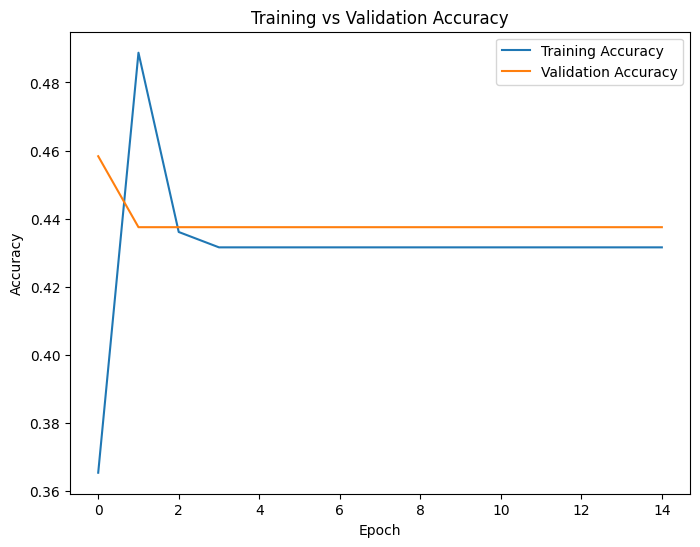

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

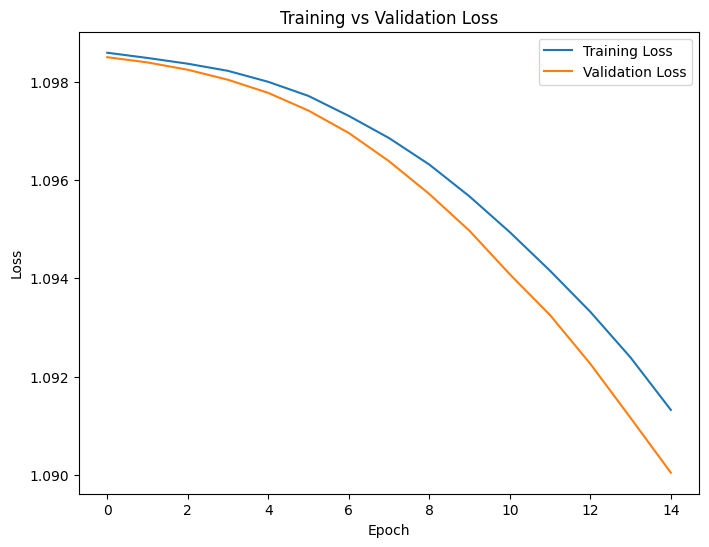

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

Predire avec X_test

In [ ]:
model = load_model("best_model.h5")

loss, acc = model.evaluate(X_test.reshape(-1, target_size, target_size, 1), y_test_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 740ms/step - accuracy: 0.6958 - loss: 54.0377


In [ ]:
# Prédiction
pred = model.predict(X_test.reshape(-1, target_size, target_size, 1))

# Convertir en classes
pred_classes = np.argmax(pred, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step


['Covid' 'Normal' 'Viral Pneumonia']


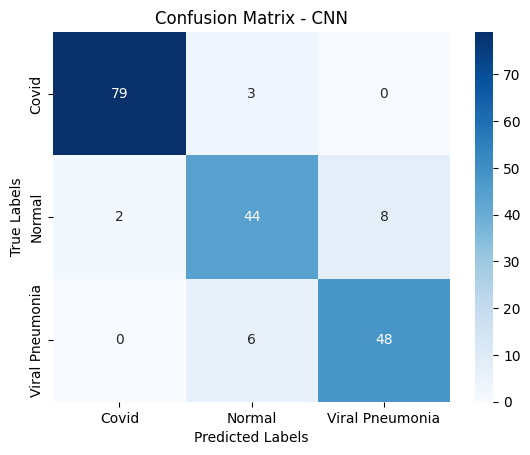

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix=confusion_matrix(y_test_encoded, pred_classes) # confusion_matrix : Lignes → vraies classes (y_test), Colonnes → classes prédites (y_pred)

# plot  confusion_matrix
print(np.unique(y_test)) # ['Covid' 'Normal' 'Viral Pneumonia'] : Alors ligne 0 = Covid, ligne 1 = Normal et Lignes → vraies classes (y_test), Colonnes → classes prédites (y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN')
plt.show()